In [1]:
import sys

sys.path.append("/home/users/arustam/fwix/operator/lib/python/")
sys.path.append("/home/users/arustam/fwix/propagator/lib/python/")

In [2]:
%load_ext autoreload
%autoreload 2
import SepVector
import CudaOperator
import CudaWEM
from pyVector import superVector
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:555: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:555: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/_core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


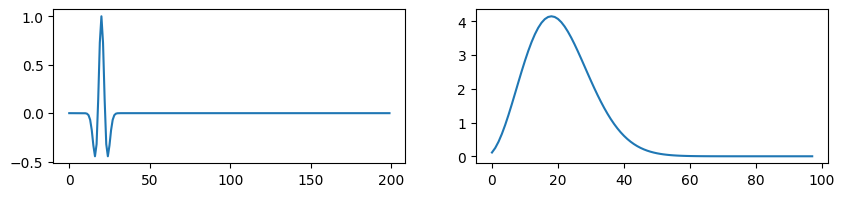

In [3]:
def ricker_wavelet(frequency, Nt, dt, t0=0):
    t = np.linspace(0, (Nt-1)*dt, Nt)
    t_shifted = t - t0
    ricker = (1 - 2 * (np.pi ** 2) * (frequency ** 2) * (t_shifted ** 2)) * np.exp(-(np.pi ** 2) * (frequency ** 2) * (t_shifted ** 2))
    return ricker

# Parameters
frequency = 10  # Ricker wavelet central frequency
Nt = 200    # Length of the wavelet in seconds
dt = 0.01      # Time sampling interval
t0 = 0.2

# Generate Ricker wavelet
wavelet = ricker_wavelet(frequency, Nt, dt, t0=t0)
W = np.fft.fft(wavelet)

df = 1/(Nt*dt)
of = 1.
maxf = 30.
nf = int((maxf-of) / df)

nf = 100
nz = 100
nbatches = [1, 10]
look = 5

f, a = plt.subplots(1,2, figsize=[10,2])
a[0].plot(wavelet, label='Ricker Wavelet')
a[1].plot(np.abs(W[int(of/df):nf]), label="Spectrue")

In [4]:
nf

100

In [5]:
nx = 500
dx = 0.01
ny = 200
dy = 0.01
dz = 0.01

ns = 1;
ds = 1

nxrec = nx
nyrec = ny

slow = SepVector.getSepVector(ns=[nx,ny,nf,nz], ds=[dx, dy, df, dz], os=[0,   0,   of,  0], storage='dataComplex')
# constant
slow[:] = 1.
# add a layer
slow[nz-2:,...] = 2.

# 4 corners
# slow[:,:,:100,:100] = 1/1**2
# slow[:,:,:100,100:] = 1/2**2
# slow[:,:,100:,:100] = 1/3**2
# slow[:,:,100:,100:] = 1/4**2

# add attenuation in the borders
npml = 20
amax = 1e-1
pml = 1j * np.linspace(0,amax,npml) 

# slow[:,:,:npml,:] += -pml[::-1, np.newaxis] 
# slow[:,:,-npml:,:] += -pml[:, np.newaxis]
# slow[:,:,:,:npml] += -pml[::-1]
# slow[:,:,:,-npml:] += -pml

den = slow.clone()
den.set(1)

model = superVector(slow, den)

wfld = SepVector.getSepVector(ns=[nx,ny,nf,ns],ds=[dx,dy,df,ds],os=[0,0,of,0], storage='dataComplex')

n_src_traces = ns
src_traces = SepVector.getSepVector(ns=[nf, n_src_traces],ds=[df, 1],os=[1, 0], storage='dataComplex')
n_rec_traces = nxrec * nyrec * ns
rec_traces = SepVector.getSepVector(ns=[nf, n_rec_traces],ds=[df, 1],os=[1, 0], storage='dataComplex')

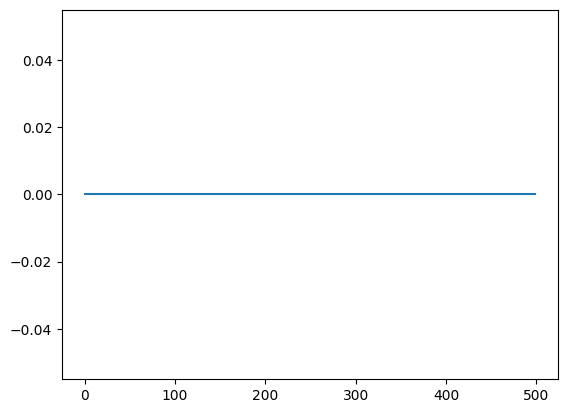

In [6]:
plt.plot(slow[0,0,0,:].imag)

In [7]:
n_rec_traces

100000

In [8]:
sx = np.random.uniform(0, (nx-1)*dx, n_src_traces).astype(np.float32) * 0 + (nx-1)*dx/2
sy = np.random.uniform(0, (ny-1)*dy, n_src_traces).astype(np.float32) * 0 + (ny-1)*dy/2
sz = np.random.uniform(0, (nz-1)*dz, n_src_traces).astype(np.float32) * 0 + 2*dz
s_ids = np.linspace(0, ns-1, ns).astype(int)

rx, ry = np.meshgrid(np.linspace(0, (nx-1)*dx, nxrec), np.linspace(0, (ny-1)*dy, nyrec))
r_ids = s_ids.repeat(rx.size)
rx = np.tile(rx.flatten(), ns)
ry = np.tile(ry.flatten(), ns)
rz = np.zeros(rx.size) + (nz-3)*dz*0

In [9]:
rx.size

100000

In [10]:
import genericIO
par = {
    "nref" : 11,
    "eps" : 0.04,
    "padx" : nx,
    "pady" : ny,
    "taperx" : 0,
    "tapery" : 0,
    "ref_look_ahead" : look
}
par = genericIO.pythonParams(par)

geometry = {
    "sx" : sx, "sy" : sy, "sz" : sz, "s_ids" : s_ids,
    "rx" : rx, "ry" : ry, "rz" : rz, "r_ids" : r_ids,
}

In [11]:
for i in range(n_src_traces):
    src_traces[i, :] = W[:nf]
propOp = CudaWEM.StreamingPropagator(
    model, rec_traces, src_traces, par, geometry, nbatches)

In [12]:
%%timeit -r 3
propOp.forward(False, model, rec_traces)

30.8 s ± 3.83 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [13]:
rec_traces.norm()

0.04026956856250763

In [14]:
x = sx//dx * dx
y = sy//dy * dy
lx = 1 - (sx-x)/dx
ly = 1 - (sy-y)/dy
lx, ly


(array([0.5000124], dtype=float32), array([0.49999452], dtype=float32))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
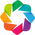

In [15]:
import holoviews as hv 
hv.extension('bokeh')
hv.output(widget_location='bottom')

In [16]:
snaps = {}
every = 10
pclip = .001

amin = pclip * np.amin(rec_traces[:].real)
amax = pclip * np.amax(rec_traces[:].real)
# wfld_c = np.clip(wfld.real, amin, amax)

for i in range(nf):
    mat = rec_traces[:,i].real
    # only look at the recorded data from the first shot
    mat = mat[:nxrec*nyrec].reshape((nyrec, nxrec))
    snaps[i] = hv.Image(mat, bounds=(0,-nyrec,nxrec,0)).opts(cmap='gray', clim=(-pclip, pclip), aspect=nxrec//nyrec)

In [17]:
# hmap = hv.HoloMap(snaps, kdims='Frequency')
# hmap

In [18]:
hv.Curve(np.abs(rec_traces[2500,:])).opts(aspect=2)

:Curve   [x]   (y)

In [19]:
all_freq = np.zeros((rec_traces.shape[0], Nt), dtype=np.complex64)


all_freq[:,int(of/df):rec_traces.shape[1]+int(of/df)] = rec_traces[:]

time = np.fft.ifft(all_freq, axis=1).real

In [20]:
snaps = {}
every = 10
pclip = .001

amin = pclip * np.amin(time[:])
amax = pclip * np.amax(time[:])

for i in range(0, Nt, every):
    mat = time[:,i].real
    mat = mat[:nxrec*nyrec].reshape((nyrec, nxrec))
    snaps[i] = hv.Image(mat, bounds=(0,-nyrec,nxrec,0)).opts(cmap='gray', clim=(-pclip, pclip), aspect=nxrec//nyrec)

In [21]:
# hmap = hv.HoloMap(snaps, kdims='Time')
# hmap

In [22]:
# mat = time[2100:2800,:].real.T
# mat = mat / np.amax(mat)

# hv.Image(mat).opts(cmap='gray', clim=(-1, 1), aspect=2)